# Using ML to Recommend Diagnostic Screening

## Overview

This tutorial creates two supervised Machine Learning models to recommend diagnostic screening for patients based on demographic and administrative information available early in a patient's admission process.

### Practical Purpose

Use existing information about a patient to determine if they may benefit from screening for undiagnosed comorbidities. This tutorial uses diabetes/prediabetes diagnosis as an example, where [early diagnosis can help prevent future complications](https://www.uchicagomedicineadventhealth.org/blog/understanding-diabetes-importance-early-detection-and-management).

### Learning Goal

In this tutorial, we’ll learn how to extract and prepare data from a dataset, create clinically-meaningful labels for diabetes/prediabetes, engineer demographic features, and train a simple supervised machine learning model to predict likelihood of abnormal lab results.

### Dataset

[MIMIC-III](https://physionet.org/content/mimiciii/1.4/) (requires credentialed access)

### Machine Learning Models

- `scikit-learn` [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- `scikit-learn` [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) 

### Tutorial Outline

1. Data Extraction and Labeling
2. Feature Engineering
3. Build Model
4. Evaluate Model Performance



## Step 1. Data Extraction and Labeling

### Objective
Import the relevant data → Prepare and label for training

### Result
Collection of admission events, labeled by patient’s cohort:
Positive: patients with evidence of diabetes risk
Negative: patients with nominal lab results

### Tables
- [ADMISSIONS](https://mimic.mit.edu/docs/iii/tables/admissions/)
- [LABEVENTS](https://mimic.mit.edu/docs/iii/tables/labevents/)
- [D_LABITEMS](https://mimic.mit.edu/docs/iii/tables/d_labitems/)
- [DIAGNOSES_ICD](https://mimic.mit.edu/docs/iii/tables/diagnoses_icd/)
- [D_ICD_DIAGNOSES](https://mimic.mit.edu/docs/iii/tables/d_icd_diagnoses/)


### Import MIMIC-III Tables

> **NOTE**: Tables are not included with notebook and assumed to be available in the `../mimic-iii/` directory

We'll use [`pandas`](https://pandas.pydata.org/) to load the tables from CSV.

In [15]:
import pandas as pd

# keep only the timestamp for labevents to find first-order times + values for
# labeling. Also include definitions of lab events
labs = pd.read_csv(
  '../mimic-iii/LABEVENTS.csv.gz',
  usecols=[
    'SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUENUM', 'VALUEUOM'
  ],
  parse_dates=['CHARTTIME']
)
d_labitems = pd.read_csv("../mimic-iii/D_LABITEMS.csv.gz")

# import  admissions and diagnoses tables
admissions = pd.read_csv(
  '../mimic-iii/ADMISSIONS.csv.gz',
  parse_dates=['ADMITTIME','DISCHTIME'])
diagnoses = pd.read_csv(
  '../mimic-iii/DIAGNOSES_ICD.csv.gz',
  usecols=['SUBJECT_ID','HADM_ID','ICD9_CODE'])
d_diag = pd.read_csv('../mimic-iii/D_ICD_DIAGNOSES.csv.gz')

### Get Patients with Previous Diabetes Diagnosis

Start to construct positive label cohort by identifying patients with existing Diagnosis

In [16]:
# get the cohort of patients with diagnosis of diabetes
diagnoses = diagnoses.assign(
  is_diabetes = (
    diagnoses['ICD9_CODE'].astype(str).str.startswith('250')
    | diagnoses['ICD9_CODE'].astype(str).str.startswith('249')
  )
)
# sanity check by merging with d_diag to get the label description
diag_labeled = diagnoses.merge(d_diag, on='ICD9_CODE', how='left')

diab_related = diag_labeled[diag_labeled['is_diabetes'] == True]
print(diab_related.head())

# get a cohort of patients with a diabetes-related diagnosis
cohort_diab = diab_related['SUBJECT_ID'].unique()
print(f"Number of patients with diabetes-related diagnosis: {len(cohort_diab)}")

     SUBJECT_ID  HADM_ID ICD9_CODE  is_diabetes  ROW_ID  \
71          117   140784     25000         True  1591.0   
91          117   164853     25000         True  1591.0   
113         123   195632     25000         True  1591.0   
206         130   113323     25000         True  1591.0   
214         130   198214     25060         True  2263.0   

                  SHORT_TITLE  \
71   DMII wo cmp nt st uncntr   
91   DMII wo cmp nt st uncntr   
113  DMII wo cmp nt st uncntr   
206  DMII wo cmp nt st uncntr   
214  DMII neuro nt st uncntrl   

                                            LONG_TITLE  
71   Diabetes mellitus without mention of complicat...  
91   Diabetes mellitus without mention of complicat...  
113  Diabetes mellitus without mention of complicat...  
206  Diabetes mellitus without mention of complicat...  
214  Diabetes with neurological manifestations, typ...  
Number of patients with diabetes-related diagnosis: 10403


### Include Patients with Multiple Abnormal Lab Results

To increase the sample size to include those who _should_ be tested for diabetes (i.e. those who are at risk due to high A1C), we want to apply a positive label even to undiagnosed patients if their labs indicate elevated risk. To reduce false-positives, omit patients with only one abnormal lab result.

#### First, determine which labs should be considered

In [17]:
# get glucose-related lab events
glucose_related_labs = d_labitems[
  d_labitems['LABEL'].str.contains('glucose', case=False, na=False) &
  d_labitems['FLUID'].str.contains('blood|plasma|serum', case=False, na=False)
]

# with a list of relevant lab types, filter the labevents table
glucose_related_lab_events = labs[
  labs['ITEMID'].isin(glucose_related_labs['ITEMID']) & labs['VALUEUOM'].notna()
]
glucose_related_lab_events['VALUEUOM'].unique()
glucose_related_lab_events.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUENUM,VALUEUOM
16,3,NaN,50931,2101-10-13 03:00:00,137.0,mg/dL
29,3,NaN,50931,2101-10-13 15:47:00,152.0,mg/dL
43,3,NaN,50931,2101-10-14 03:00:00,118.0,mg/dL
87,3,NaN,50931,2101-10-15 03:30:00,105.0,mg/dL
107,3,NaN,50931,2101-10-15 12:15:00,126.0,mg/dL


#### Choose Nominal Threshold to Interpret Results

Source for normal blood glucose levels:
- https://my.clevelandclinic.org/health/diagnostics/12363-blood-glucose-test

> **NOTE**: used for demonstration purposes only, not for medical decision-making
> To improve accuracy of model, medical professionals should be consulted for the determination of normal blood glucose levels.


In [18]:
lab_abnormal_glucose = glucose_related_lab_events[
  (glucose_related_lab_events['VALUENUM'] < 70) | (glucose_related_lab_events['VALUENUM'] > 110)
]
lab_abnormal_glucose.size
cohort_abnormal_glucose = lab_abnormal_glucose['SUBJECT_ID'].unique()

# get a cohort of patients with multiple abnormal glucose lab events
lab_abnormal_glucose_multi = lab_abnormal_glucose[
    lab_abnormal_glucose['SUBJECT_ID'].isin(
        lab_abnormal_glucose['SUBJECT_ID'].value_counts()[lambda x: x > 1].index
    )
]
lab_abnormal_glucose_multi.size
cohort_abnormal_glucose_multi = lab_abnormal_glucose_multi['SUBJECT_ID'].unique()


#### Visualize Cohort Relationship

How do the Diagnosed and Undiagnosed cohorts we just constructed overlap? It looks like we signifcantly increase our sample size by including patients with abnormal glucose labs.

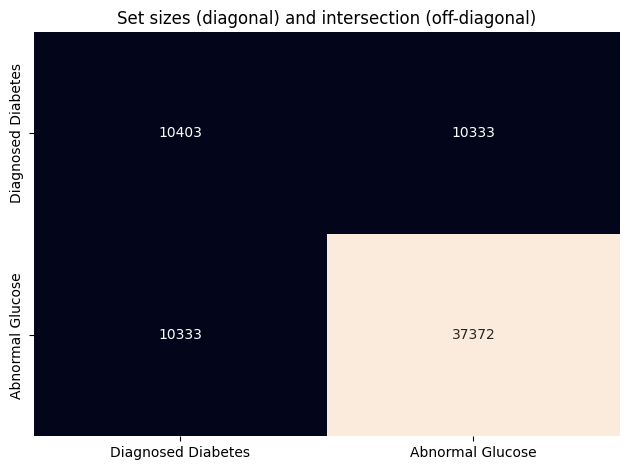

{'Only Diagnosed Diabetes': 70, 'Both': 10333, 'Only Abnormal Glucose': 27039}


In [19]:
# Visualize relationship of cohorts

import matplotlib.pyplot as plt
import seaborn as sns
def overlap_heatmap(a, b, labels=("A", "B")):
    A, B = set(a), set(b)
    inter = A & B

    df = pd.DataFrame(
        [[len(A),       len(inter)],
         [len(inter),   len(B)]],
        index=[labels[0], labels[1]],
        columns=[labels[0], labels[1]],
    )

    ax = sns.heatmap(df, annot=True, fmt="d", cbar=False)
    ax.set_title("Set sizes (diagonal) and intersection (off-diagonal)")
    plt.tight_layout()
    plt.show()

    # print the Venn-style counts to help interpret the heatmap
    print({
        f"Only {labels[0]}": len(A - B),
        "Both": len(inter),
        f"Only {labels[1]}": len(B - A),
    })

overlap_heatmap(cohort_diab, cohort_abnormal_glucose, labels=("Diagnosed Diabetes", "Abnormal Glucose"))


#### Add Patients with Abnormal A1C Labs

Source of normal A1C levels:
- https://my.clevelandclinic.org/health/diagnostics/9731-a1c
> **NOTE**: used for demonstration purposes only, not for medical decision-making
> To improve accuracy of model, medical professionals should be consulted for the determination of normal A1C levels.

Visualizing the results, we add a modest number of patients that were not already in the positive-label cohort.

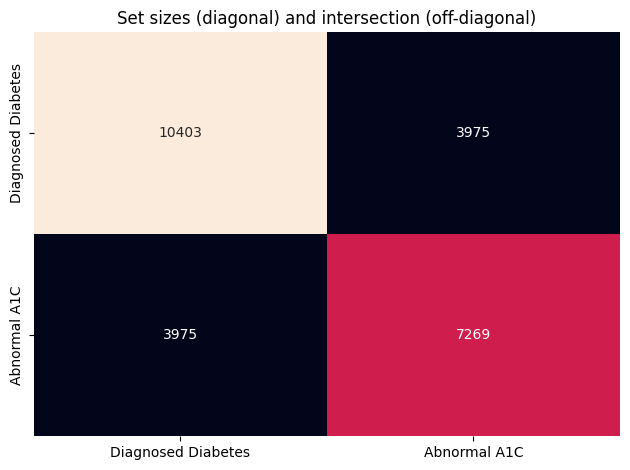

{'Only Diagnosed Diabetes': 6428, 'Both': 3975, 'Only Abnormal A1C': 3294}


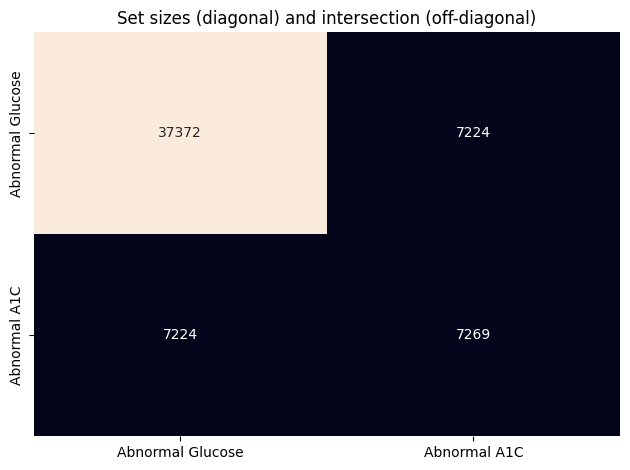

{'Only Abnormal Glucose': 30148, 'Both': 7224, 'Only Abnormal A1C': 45}


In [20]:
a1c_related_labs = d_labitems[
  d_labitems['LABEL'].str.contains(
    'a1c|hba1c|glycohemoglobin',
    case=False,
    na=False)
]

a1c_related_lab_events = labs[
  labs['ITEMID'].isin(a1c_related_labs['ITEMID']) & labs['VALUEUOM'].notna()
]
a1c_related_lab_events['VALUEUOM'].unique()

lab_abnormal_a1c = a1c_related_lab_events[
  (a1c_related_lab_events['VALUENUM'] >= 5.7)
]
cohort_abnormal_a1c = lab_abnormal_a1c['SUBJECT_ID'].unique()

# Visualize relationship of cohorts
overlap_heatmap(cohort_diab, cohort_abnormal_a1c, labels=("Diagnosed Diabetes", "Abnormal A1C"))
overlap_heatmap(cohort_abnormal_glucose, cohort_abnormal_a1c, labels=("Abnormal Glucose", "Abnormal A1C"))

#### Assemble Positive-label Cohort

Combine:
- Patients Diagnosed with Diabetes
- Patients with Multiple Abnormal Blood Glucose Labs
- Patients with Abnormal A1C Labs

Result is `34981` patients for positive-label group

In [21]:
# Positive-Label Cohort by merging those diagnosed with those with abnormal glucose or A1C
positive_label_cohort = set(cohort_diab) | set(cohort_abnormal_glucose_multi) | set(cohort_abnormal_a1c)
len(positive_label_cohort)


34981

### Get Patients with Normal Lab Results for Negative-Label

To provide negative training examples, we examing the `LABEVENTS` table for patients that have only had normal relevant lab results. Once this cohort is assembled, we assess the cohort's size

> **NOTE**: We have an imbalance of more positive labels by a ration of almost `10:1`. This must be taken into account when training and evaluating our models

In [22]:
lab_nominal_glucose = glucose_related_lab_events[
  (glucose_related_lab_events['VALUENUM'] >= 70) & (glucose_related_lab_events['VALUENUM'] <= 110)
]
cohort_nominal_glucose = lab_nominal_glucose['SUBJECT_ID'].unique()

lab_nominal_a1c = a1c_related_lab_events[
  (a1c_related_lab_events['VALUENUM'] < 5.7)
]
lab_nominal_a1c.size
cohort_nominal_a1c = lab_nominal_a1c['SUBJECT_ID'].unique()

# Negative Label Cohort by merging those with nominal glucose and a1c, but not in the positive label cohort
negative_label_cohort = (set(cohort_nominal_glucose) | set(cohort_nominal_a1c)) - positive_label_cohort
len(negative_label_cohort)


3612

#### Assemble our Labeled Dataset

Our actual training set will consist of each patient’s first admission record to emphasize our goal of providing a prediction model that is used as an early-diagnosis aid.



In [23]:
first_adm = (
    admissions.sort_values(['SUBJECT_ID','ADMITTIME'])
    .assign(rn=lambda df: df.groupby('SUBJECT_ID').cumcount()+1)
    .query('rn==1')
)

positive_and_negative_ids = set(positive_label_cohort) | set(negative_label_cohort)
first_admissions_in_label_cohorts = first_adm[first_adm['SUBJECT_ID'].isin(positive_and_negative_ids)]

first_admissions_in_label_cohorts['label'] = first_admissions_in_label_cohorts['SUBJECT_ID'].apply(
    lambda x: x in positive_label_cohort
)
first_admissions_in_label_cohorts['label'].value_counts()


/var/folders/n2/79rl6kvj3lq1qfjnjpy7zspc0000gn/T/ipykernel_21227/3600845849.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_admissions_in_label_cohorts['label'] = first_admissions_in_label_cohorts['SUBJECT_ID'].apply(


label
True     34981
False     3612
Name: count, dtype: int64

## Step 2. Feature Engineering

Now that we have a labeled training dataset, we have to choose which features of the dataset to use as predictive attributes and prepare them for training.

### Objective
Choose and prepare predictive features for training

### Result
Training Dataset ready for supervised learning 

### Tables
- [PATIENTS](https://mimic.mit.edu/docs/iii/tables/patients/)

### Define Categorical Features

- [ADMISSION_TYPE](https://mimic.mit.edu/docs/iii/tables/admissions/#admission_type)
- [ADMISSION_LOCATION](https://mimic.mit.edu/docs/iii/tables/admissions/#admission_location)
- [INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY](https://mimic.mit.edu/docs/iii/tables/admissions/#insurance-language-religion-marital_status-ethnicity)
- [GENDER](https://mimic.mit.edu/docs/iii/tables/patients/#gender)

In [24]:
cat_features = [
  'ADMISSION_TYPE',
  'ADMISSION_LOCATION',
  'INSURANCE',
  'LANGUAGE',
  'RELIGION',
  'MARITAL_STATUS',
  'ETHNICITY',
  'GENDER'
]

### Merge Patients Table for Gender and Age

The [ADMISSIONS](https://mimic.mit.edu/docs/iii/tables/admissions/) Table has most of the demographic and administrative features we're initially interested in, but we'd also like to include Gender and Age. We can get these by merging with the [PATIENTS](https://mimic.mit.edu/docs/iii/tables/patients/) table on [`SUBJECT_ID`](https://mimic.mit.edu/docs/iii/tables/admissions/#subject_id-hadm_id) and calculating age at admission.

In [25]:
patients = pd.read_csv(
  '../mimic-iii/PATIENTS.csv.gz',
  parse_dates=['DOB'])
# merge with patients table to add gender and date of birth
first_admissions_in_label_cohorts = first_admissions_in_label_cohorts.merge(
    patients[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)

# to avoid int64 overflow, set all dates of birth to the year 2000 if they are before 2000
# (this addresses the age shift to comply with HIPAA for patients older than 89)
first_admissions_in_label_cohorts['DOB'] = (
  first_admissions_in_label_cohorts['DOB'].apply(
      lambda d: d.replace(year=2000) if d.year < 2000 else d
  )
)
# calculate age at admission
first_admissions_in_label_cohorts['age_at_admission'] = (
    (first_admissions_in_label_cohorts['ADMITTIME'] - first_admissions_in_label_cohorts['DOB']).dt.days / 365.25
).clip(lower=0, upper=120)
first_admissions_in_label_cohorts['ADMITTIME'].describe()
first_admissions_in_label_cohorts['DOB'].describe()
first_admissions_in_label_cohorts['age_at_admission'].describe()

first_admissions_in_label_cohorts.info()

# note that age_at_admission is a numeric feature and construct our final list of features
num_features = ['age_at_admission']
features = cat_features + num_features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38593 entries, 0 to 38592
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                38593 non-null  int64         
 1   SUBJECT_ID            38593 non-null  int64         
 2   HADM_ID               38593 non-null  int64         
 3   ADMITTIME             38593 non-null  datetime64[ns]
 4   DISCHTIME             38593 non-null  datetime64[ns]
 5   DEATHTIME             4190 non-null   object        
 6   ADMISSION_TYPE        38593 non-null  object        
 7   ADMISSION_LOCATION    38593 non-null  object        
 8   DISCHARGE_LOCATION    38593 non-null  object        
 9   INSURANCE             38593 non-null  object        
 10  LANGUAGE              23884 non-null  object        
 11  RELIGION              38163 non-null  object        
 12  MARITAL_STATUS        36136 non-null  object        
 13  ETHNICITY       

### Handle Missing Feature Values

Not all admissions have values for every feature. We need to figure out how to handle that. In most cases we'll use a value like "Unknown" for missing values. The one exception is that we'll assume a missing language value implies English, since this dataset was collected in America.

In [ ]:
# show which features have missing values
first_admissions_in_label_cohorts[features].isna().sum()

ADMISSION_TYPE            0
ADMISSION_LOCATION        0
INSURANCE                 0
LANGUAGE              14709
RELIGION                430
MARITAL_STATUS         2457
ETHNICITY                 0
GENDER                    0
age_at_admission          0
dtype: int64

In [29]:
# assume that missing language means English
first_admissions_in_label_cohorts['LANGUAGE'] = first_admissions_in_label_cohorts['LANGUAGE'].fillna('ENGL')

# mark missing marital status and religion as 'Unknown'
first_admissions_in_label_cohorts['MARITAL_STATUS'] = first_admissions_in_label_cohorts['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

# mark missing religion as 'NOT SPECIFIED'
first_admissions_in_label_cohorts['RELIGION'] = first_admissions_in_label_cohorts['RELIGION'].fillna('NOT SPECIFIED')

first_admissions_in_label_cohorts[features].isna().sum()

ADMISSION_TYPE        0
ADMISSION_LOCATION    0
INSURANCE             0
LANGUAGE              0
RELIGION              0
MARITAL_STATUS        0
ETHNICITY             0
GENDER                0
age_at_admission      0
dtype: int64

### One-hot Encode Categorical Features

Scikit-learn’s DecisionTreeClassifier can’t take raw strings, so we use One-hot Encoding to prepare these features.

In [30]:
# one-hot encode the categorical features
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

## Step 3. Build Model

Our Dataset is ready for training - most of the work is done! Now we use the `scikit-learn` library to build our models.

### Objective
Split Dataset into Training and Testing sets → Fit models to Training Dataset

### Result
Decision Tree and Random Forest prediction models


### Train Test Split

We need to save some of our dataset to evaluate our models after training. We don’t want to test the model with examples it saw during training, so we set 20% aside for testing.

In [ ]:
RANDOM_STATE = 1138
# Features
X = first_admissions_in_label_cohorts[features].copy()

# labels
y = first_admissions_in_label_cohorts['label'].copy()

# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)


### Fit DecisionTreeClassifier To Dataset

In [40]:
# train a shallow tree classifier to do some initial evaluation
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
    max_depth=4, # shallow tree for interpretability
    class_weight='balanced',
    random_state=RANDOM_STATE
)

dt_model = Pipeline([
    ('preprocess', preprocess),
    ('tree', clf)
])

dt_model.fit(X_train, y_train)


/Users/seth/code/msai/msai-54315-ai-for-healthcare/assignment-4-self-learning-tutorial/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ADMISSION_TYPE',
                                                   'ADMISSION_LOCATION',
                                                   'INSURANCE', 'LANGUAGE',
                                                   'RELIGION', 'MARITAL_STATUS',
                                                   'ETHNICITY', 'GENDER'])])),
                ('tree',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                                        random_state=1138))])

### Fit RandomForestClassifier to Dataset

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,              # let trees grow, control with min_samples_leaf
    min_samples_leaf=5,          # stabilizes splits on imbalance
    max_features='sqrt',         # good default
    class_weight='balanced',     # handle ~9:1 imbalance
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf_model = Pipeline([
    ('prep', preprocess),
    ('rf', rf)
])

rf_model.fit(X_train, y_train)


/Users/seth/code/msai/msai-54315-ai-for-healthcare/assignment-4-self-learning-tutorial/.venv/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ADMISSION_TYPE',
                                                   'ADMISSION_LOCATION',
                                                   'INSURANCE', 'LANGUAGE',
                                                   'RELIGION', 'MARITAL_STATUS',
                                                   'ETHNICITY', 'GENDER'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=5, n_estimators=400,
                                        n_jobs=-1, random_state=1138))])

## Step 4. Evaluate Model Performance

### Objective

Use metrics to understand performance of our models

### Result

Informed ideas for future improvements

In [39]:
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

def evaluate_model(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:,1]

  print(classification_report(y_test, y_pred))
  print("ROC AUC:", roc_auc_score(y_test, y_prob))

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)



### Decision Tree Evaluation

              precision    recall  f1-score   support

       False       0.19      0.57      0.29       722
        True       0.94      0.75      0.84      6997

    accuracy                           0.73      7719
   macro avg       0.57      0.66      0.56      7719
weighted avg       0.87      0.73      0.79      7719

ROC AUC: 0.7124114727443538


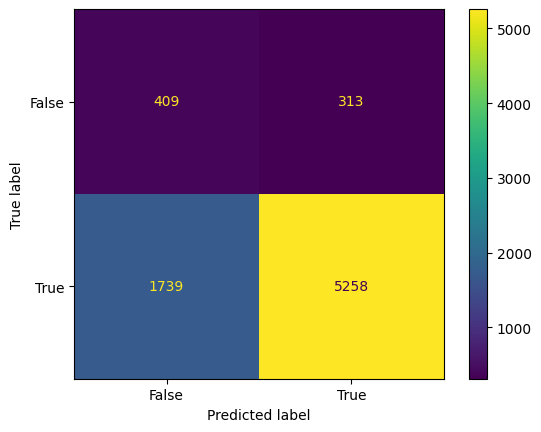

In [41]:
evaluate_model(dt_model, X_test, y_test)


### Evaluate Random Forest

              precision    recall  f1-score   support

       False       0.20      0.52      0.29       722
        True       0.94      0.79      0.86      6997

    accuracy                           0.76      7719
   macro avg       0.57      0.65      0.57      7719
weighted avg       0.87      0.76      0.80      7719

ROC AUC: 0.7157125511249974


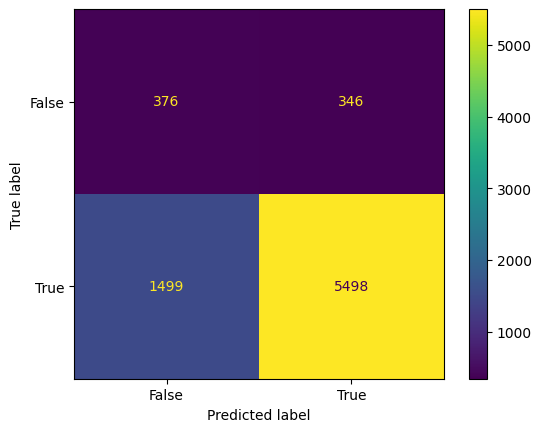

In [42]:
evaluate_model(rf_model, X_test, y_test)